In [197]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(42)


In [198]:
def ftqc_scalar(values, D, Delta, max_iters=10):
    """Simplified FTQC for scalar values."""
    N = len(values)
    agents = [{
        'y': 2 * int(values[i] / Delta),
        'z': 2
    } for i in range(N)]
    
    # Token passing rounds
    for _ in range(D):
        msgs = [0] * N
        for i in range(N):
            if agents[i]['z'] > 1:
                t = agents[i]['y'] // agents[i]['z']
                agents[i]['y'] -= t
                agents[i]['z'] -= 1
                msgs[i] = t
        
        # Ring communication
        for i in range(N):
            receiver = (i + 1) % N
            agents[receiver]['y'] += msgs[i]
            agents[receiver]['z'] += 1 if msgs[i] != 0 else 0

    # Termination with max/min consensus
    consensus_vals = []
    for i in range(N):
        m_val = agents[i]['y'] / agents[i]['z']
        consensus_vals.append(Delta * m_val)
        
    return np.mean(consensus_vals)  # Simplified consensus approximation



In [199]:
def ftqc_dgd(agents, data, alpha=0.01, D=3, Delta=0.1, steps=100):
    """FTQC-DGD for federated linear regression."""
    N = len(agents)
    w_hist = [np.zeros(agents[0].w.shape) for _ in range(N)]
    
    for k in tqdm(range(steps)):
        # Local stochastic gradient computation
        local_values = []
        for i, agent in enumerate(agents):
            X, y = data[i]
            idx = np.random.randint(0, len(X))
            grad = agent.gradient(X[idx:idx+1], y[idx:idx+1])
            w_temp = agent.w - alpha * grad
            local_values.append(w_temp)
        
        # Vector coordination via FTQC (per dimension)
        w_next = np.zeros(local_values[0].shape)
        for dim in range(w_next.shape[0]):
            dim_vals = [w[dim] for w in local_values]
            w_next[dim] = ftqc_scalar(dim_vals, D, Delta)
            
        # Update weights
        for i in range(N):
            agents[i].w = w_next.copy()
            w_hist[i] = np.vstack([w_hist[i], w_next])
            
    return w_hist, agents


In [200]:
class LinearAgent:
    def __init__(self, w_init):
        self.w = w_init.copy()
    
    def gradient(self, X, y):
        n = X.shape[0]  # number of samples
        return (2/n) * X.T @ (X @ self.w - y)  # Correct gradient computation for MSE loss
    def predict(self, X):
        """Predict output for input X."""
        return X @ self.w


In [201]:
def create_data(true_w, N, points_per_agent, noise=0.3):
    data = []
    for i in range(N):
        X = np.random.randn(points_per_agent, len(true_w))
        X[:,0] = 1  # Bias term
        y = X @ true_w + noise * np.random.randn(points_per_agent)
        data.append((X, y))
    return data


In [202]:
true_w = np.array([1.0, 2.0])

# Create agents and data
num_agents = 3
agents = [LinearAgent(np.zeros(2)) for _ in range(num_agents)]
data = create_data(true_w, num_agents, 50)


In [203]:
w_history, trained_agents = ftqc_dgd(
    agents=agents,
    data=data,
    alpha=0.01,  # Reduced learning rate for stability
    D=num_agents,  # Graph diameter
    Delta=0.001,    # Reduced quantization level for better precision
    steps=1000    # Increased number of steps
)


100%|██████████| 1000/1000 [00:00<00:00, 36322.50it/s]


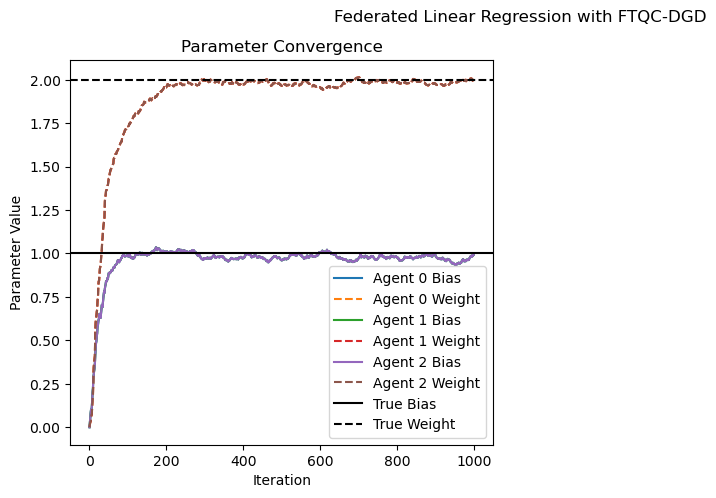

In [204]:
plt.figure(figsize=(12, 5))
plt.suptitle("Federated Linear Regression with FTQC-DGD")

# Parameters convergence
plt.subplot(1, 2, 1)
for i in range(num_agents):
    plt.plot(w_history[i][:,0], label=f'Agent {i} Bias')
    plt.plot(w_history[i][:,1], linestyle='--', label=f'Agent {i} Weight')
plt.axhline(y=true_w[0], color='k', linestyle='-', label='True Bias')
plt.axhline(y=true_w[1], color='k', linestyle='--', label='True Weight')
plt.ylabel('Parameter Value')
plt.xlabel('Iteration')
plt.title('Parameter Convergence')
plt.legend()


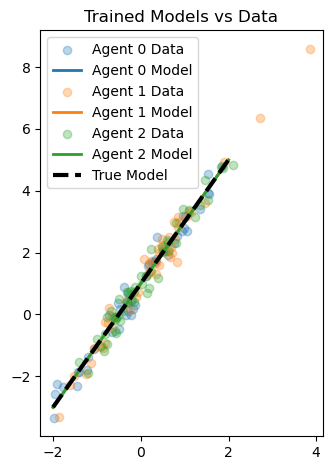

In [205]:
plt.subplot(1, 2, 2)
X_test = np.linspace(-2, 2, 100).reshape(-1,1)
X_test_b = np.hstack([np.ones_like(X_test), X_test])
for i, (X, y) in enumerate(data):
    plt.scatter(X[:,1], y, alpha=0.3, label=f'Agent {i} Data')
    plt.plot(X_test, X_test_b @ trained_agents[i].w, linewidth=2, label=f'Agent {i} Model')
plt.plot(X_test, X_test_b @ true_w, 'k--', linewidth=3, label='True Model')
plt.title('Trained Models vs Data')
plt.legend()

plt.tight_layout()
plt.show()

In [206]:
print("\nFinal Parameters:")
for i, agent in enumerate(trained_agents):
    print(f"Agent {i}: Bias={agent.w[0]:.4f}, Weight={agent.w[1]:.4f} (True: {true_w[0]}, {true_w[1]})")


Final Parameters:
Agent 0: Bias=0.9943, Weight=1.9997 (True: 1.0, 2.0)
Agent 1: Bias=0.9943, Weight=1.9997 (True: 1.0, 2.0)
Agent 2: Bias=0.9943, Weight=1.9997 (True: 1.0, 2.0)


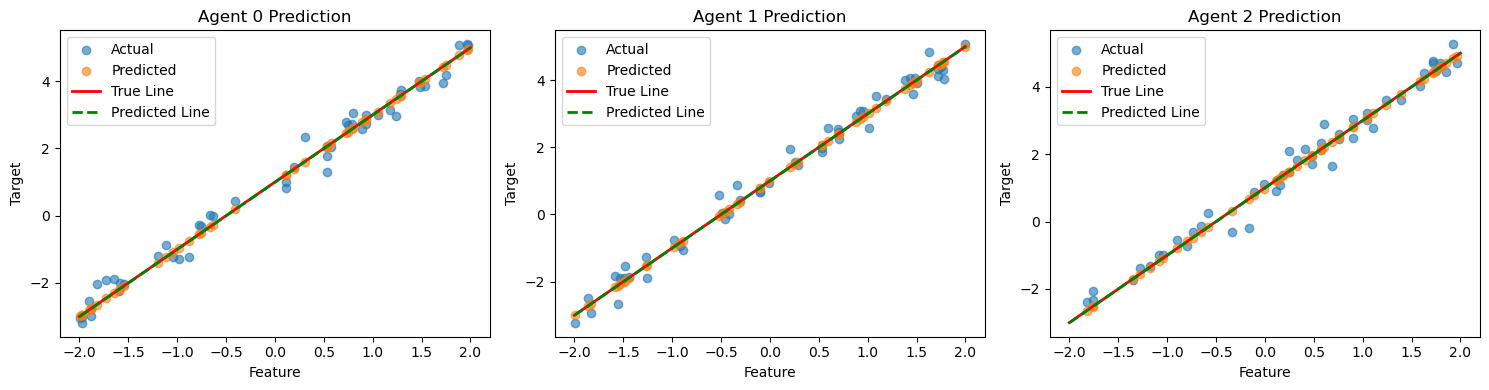

In [207]:
# Create a new test dataset for each agent
test_points = 50
X_tests = []
y_tests = []

for idx in range(num_agents):
    # Use the same true_w for generating ground truth
    X_test_agent = np.hstack([np.ones((test_points, 1)), np.random.uniform(-2, 2, (test_points, 1))])
    y_test_agent = X_test_agent @ true_w + np.random.normal(0, 0.3, test_points)
    X_tests.append(X_test_agent)
    y_tests.append(y_test_agent)

# Plot predictions vs actual for each agent
plt.figure(figsize=(15, 4))
for idx, agent in enumerate(trained_agents):
    plt.subplot(1, num_agents, idx + 1)
    
    # Scatter plots
    y_pred = agent.predict(X_tests[idx])
    plt.scatter(X_tests[idx][:, 1], y_tests[idx], label='Actual', alpha=0.6)
    plt.scatter(X_tests[idx][:, 1], y_pred, label='Predicted', alpha=0.6)
    
    # Add regression lines
    x_line = np.linspace(-2, 2, 100)
    X_line = np.hstack([np.ones((100, 1)), x_line.reshape(-1, 1)])
    
    # True line
    y_true = X_line @ true_w
    plt.plot(x_line, y_true, 'r-', label='True Line', linewidth=2)
    
    # Predicted line
    y_pred_line = agent.predict(X_line)
    plt.plot(x_line, y_pred_line, 'g--', label='Predicted Line', linewidth=2)
    
    plt.title(f'Agent {idx} Prediction')
    plt.xlabel('Feature')
    plt.ylabel('Target')
    plt.legend()

plt.tight_layout()
plt.show()